In [136]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [137]:
alfa, m, N = 1.0, 1.0, 50

In [138]:
path = os.getcwd()
path = path[:-2]
sys.path.append(path)

In [139]:
def RK4_vec(t, dt, n, s, func):
    k1 = np.zeros(n)
    k2 = np.zeros(n)
    k3 = np.zeros(n)
    k4 = np.zeros(n)
    w = np.zeros(n)
    for i in range(n):
        w[i] = s[i]
    func(t, w, k1)
    for i in range(n):
        w[i] = s[i] + dt/2 * k1[i]
    func(t + dt/2, w, k2)
    for i in range(n):
        w[i] = s[i] + dt/2 * k2[i]
    func(t + dt/2, w, k3)
    for i in range(n):
        w[i] = s[i] + dt * k3[i]
    func(t + dt, w, k4)
    for i in range(n):
        s[i] += dt/6 * (k1[i] + 2*k2[i] + 2*k3[i] + k4[i])


In [140]:
def derivatives(t: float, s: np.array, k: np.array) -> None:
    alfa, m, N = 1.0, 1.0, 50

    for i in range(1, N):
        k[i] = s[i+N+1]  # x
        k[i+N+1] = (alfa/m)*(s[i-1] - 2*s[i] + s[i+1])  # v
    
    k[0] = 0
    k[N] = 0
    k[N+1] = 0
    k[2*N+1] = 0

In [141]:
alfa, m, N = 1.0, 1.0, 50  # N+1 - liczba atomów
dt, dx = 0.02, 0.1
n = 5000 # liczba kroków czasowych
sigma = 3*dx
t_max = n*dt
x_max = N*dx
t_vec = np.linspace(0.0, t_max, n+1)
x_vec = np.linspace(0, N, N+1)
s = np.zeros(2*N+2)

### 1. Symulacja propagacji zaburzeń w łańcuchu

In [142]:
def init_cond(): # war. początkowy
    for i in range(1, N+1):
        s[i] = i*dx + (dx/3)*np.exp( -((i*dx - 0.5*x_max)**2)/(2*sigma**2) )

In [143]:
x, v, T, U = np.zeros((N+1, n+1)), np.zeros((N+1, n+1)), np.zeros(n+1), np.zeros(n+1)
x_temp = np.copy(x) # tablica do wychyleń cząstek

In [144]:
i, t = 0, 0
init_cond()
while i <= n:
    RK4_vec(t, dt, 2*N+2, s, derivatives)
    t += dt

    for j in range(N+1):
        x[j][i] = s[j]
        v[j][i] = s[j+N+1]
        x_temp[j][i] = x[j][i] - dx*j

    for k in range(N+1):
        T[i] += 0.5*m*(v[k][i])**2
    i += 1

i = 0
while i <= n:
    for k in range(1, N+1):
        U[i] += 0.5*alfa*( x[k-1][i] - x[k][i] + dx )**2
    i += 1

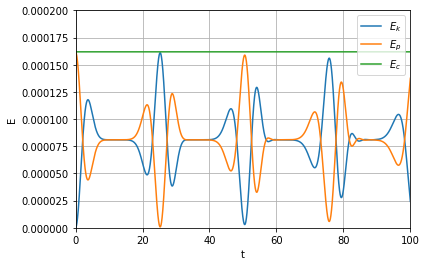

In [145]:
plt.plot(t_vec, T, label="Kinetic Energy")
plt.plot(t_vec, U, label="Potential Energy")
plt.plot(t_vec, T+U, label="Total Energy")
plt.xlabel('t')
plt.ylabel('E')
plt.legend()
plt.tight_layout()
plt.show()

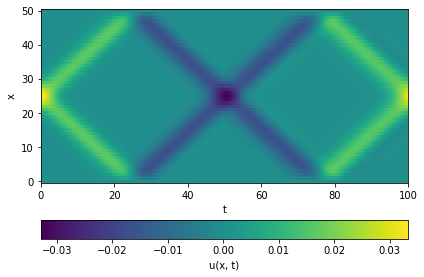

In [146]:
plt.pcolormesh(t_vec, x_vec, x_temp, shading='auto')
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label('u(x, t)')
plt.xlabel('t')
plt.ylabel('x')
# plt.xlim(0.0, 5.0)
plt.tight_layout()
plt.show()

### 2. Rezonans mechaniczny

In [147]:
alfa, m, N = 1.0, 1.0, 50  # N+1 - liczba atomów
dt, dx = 0.02, 0.1
sigma = 3*dx
x_max = N*dx
x_vec = np.linspace(0, N, N+1)
s = np.zeros(2*N+2)

nn = [0.9, 1.0, 1.1, 1.5, 2.0, 5.0]
omega_n = [ 2*np.sqrt(alfa/m)*abs(np.sin(np.pi*nn[i]/(2*N))) for i in range(len(nn)) ]
t_max = [40*np.pi/(omega_n[i]) for i in range(len(omega_n))]
n = [int(t_max[i]/dt) for i in range(len(t_max))]  # czas
t_vec = np.linspace(0.0, t_max[5], n[5]+1)

x, v, T, U = np.zeros((N+1, n[5]+1)), np.zeros((N+1, n[5]+1)), np.zeros(n[5]+1), np.zeros(n[5]+1)
x_temp = np.copy(x) # tablica do wychyleń cząstek

In [148]:
def init_cond_res(): # war. początkowy
    for i in range(1, N+1):
        s[i] = i*dx

def derivatives_res(t: float, s: np.array, k: np.array) -> None:
    alfa, m, N, F = 1.0, 1.0, 50, 0.01

    for i in range(1, N):
        k[i] = s[i+N+1]  # x
        k[i+N+1] = (alfa/m)*(s[i-1] - 2*s[i] + s[i+1])  # v
    
    k[0] = 0
    k[N] = 0
    k[N+1] = 0
    k[2*N+1] = 0
    k[N+2] = (alfa/m)*(s[0] - 2*s[1] + s[2]) + (F/m)*np.sin(omega_n[5]*t)

In [149]:
i, t = 0, 0
init_cond_res()
while i <= n[5]:
    RK4_vec(t, dt, 2*N+2, s, derivatives_res)
    t += dt

    for j in range(N+1):
        x[j][i] = s[j]
        v[j][i] = s[j+N+1]
        x_temp[j][i] = x[j][i] - dx*j
    i += 1

i = 0
while i <= n[5]:
    for k in range(N+1):
        T[i] += 0.5*m*(v[k][i])**2
    i += 1

i = 0
while i <= n[5]:
    for k in range(1, N+1):
        U[i] += 0.5*alfa*( x[k-1][i] - x[k][i] + dx )**2
    i += 1

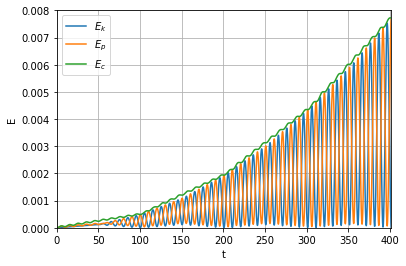

In [150]:
plt.plot(t_vec, T)
plt.plot(t_vec, U)
plt.plot(t_vec, T+U)
plt.grid()
plt.xlim(0.0, t_max[5])
plt.ylim(0.0, 0.008)
plt.xlabel('t')
plt.ylabel('E')
plt.legend([r'$E_{k}$', r'$E_{p}$', r'$E_{c}$'], loc=0)
plt.show()

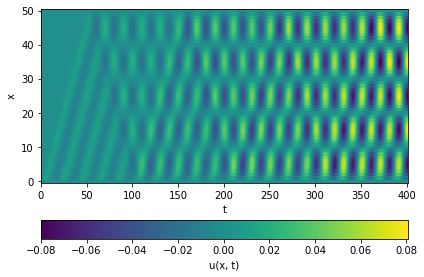

In [151]:
plt.pcolormesh(t_vec, x_vec, x_temp, shading='auto')
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label('u(x, t)')
plt.xlabel('t')
plt.ylabel('x')
plt.tight_layout()
plt.show()